# Numerical methods for the Schrodinger equation

##### by Justin Cai and Sam Bateman

In [1]:
from tise_code import *

## Solving the time-independent Schrodinger equation

Recall the that time-independent Schrodinger equation (TISE) is 

$$-\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2} + V \psi = E\psi.$$

When solving the time-independet Schrodinger equation (TISE), we are faced with solving a boundary value problem (BVP), or finding a solution to a differential equation with the solution being specified at two or more points. This is contrasted with an initial value problem (IVP), where we want to find a solution with the solution only specified at one point. For the TISE, if we restrict our particle to the finite domain $[a, b]$, then we'll have that $\psi(a)=0=\psi(b)$ as our boundary conditions.

### Shooting method

One method to solving boundary value problems is called the shooting method. The shooting method turns the problem into an initial value problem by starting at one of the boundaries, guessing an initial free parameter, solving up to the boundary (that is, "shooting" to the boundary), and checking if our solution matches the boundary condition. If it does not, we update our guess on our free parameter and then repeat this process until our solution is sufficiently close to the boundary condition.

Let's see this in a simple scenario with an infinite square well. Recall that the potential of an infinite square is 

$$V(x) = \begin{cases}0 & 0 \leq x \leq L \\ \infty & \text{otherwise} \end{cases},$$

so we get the boundary conditions $\psi(0)=0=\psi(L)$ discussed earlier. We'll have to make a guess for the initial slope, so turning this into an IVP, we have $\psi(0)=0, \psi'(0)=s$, where $s$ is a free parameter. For arbitrary potentials, we also don't know $E$, the total energy of the system, but for now, we'll plug in the analytic solution for the energy of an infinite square well,

$$E_n = \frac{n^2 \pi^2 \hbar^2}{2mL^2}.$$

For convenience, we'll also set $m=1$ and $h=1$ (so $\hbar = \frac{1}{2\pi}$). If we solve this IVP with the correct energy, then we see that the initial slope doesn't really matter:

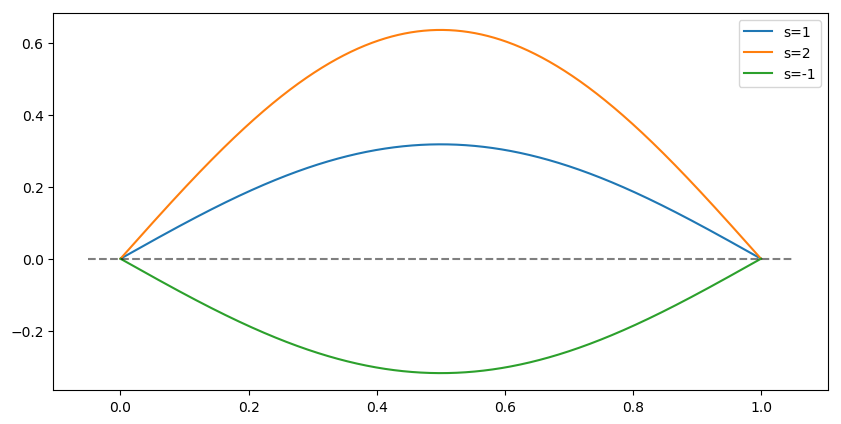

In [2]:
n = 1
L = 1
E = ISW_energy(n, L)
V = lambda x: 0
res1 = solve_tise(E, V, 0, L, s=1, max_step=1e-3)
res2 = solve_tise(E, V, 0, L, s=2, max_step=1e-3)
res3 = solve_tise(E, V, 0, L, s=-1, max_step=1e-3)

fig, ax = plt.subplots(dpi=100, figsize=(10, 5))
ax.plot(res1.t, res1.y[0], label="s=1")
ax.plot(res2.t, res2.y[0], label="s=2")
ax.plot(res3.t, res3.y[0], label="s=-1")
x_axis(ax)
ax.legend();

As we can see, assuming we have the right energy, the initial energy only rescales the wave function. And it turns out that if you satisify the TISE and the boundary conditions, you only need to scale your solution by 

$$C = \left(\int_{-\infty}^{\infty} \psi(x)^2 dx\right)^{-1}$$

to satisfy normalization.

However, what if we do not know $E$? The choice of $E$ does matter, so an incorrect choice of $E$ might not satisfy the boundary conditions. In the example below, we solve the IVP but with the energy given perturbed a small amount from the actual energy.

0.0005271889957662523
0.001109764195982837


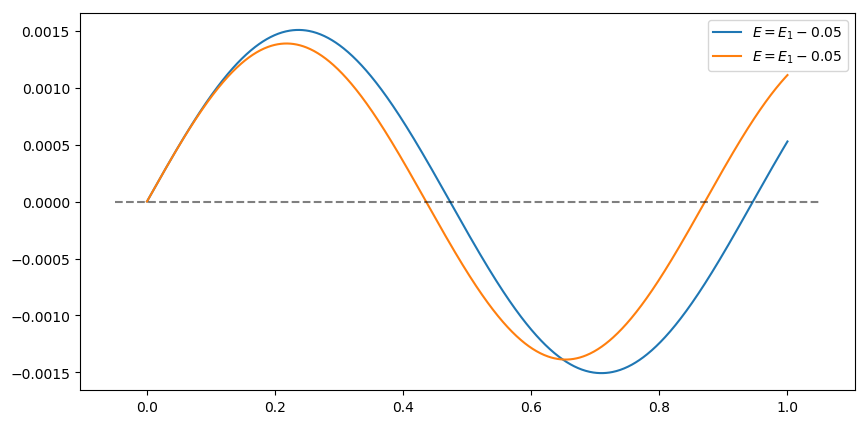

In [3]:
dE = .05
res1 = solve_tise(E-dE, V, 0, L, max_step=1e-3)
res2 = solve_tise(E+dE, V, 0, L, max_step=1e-3)

print(res1.y[0, -1])
print(res2.y[0, -1])

fig, ax = plt.subplots(dpi=100, figsize=(10, 5))
ax.plot(res1.t, res1.y[0], label=f"$E=E_1-{dE}$")
ax.plot(res2.t, res2.y[0], label=f"$E=E_1-{dE}$")
x_axis(ax)
ax.legend();

Instead of guessing the initial slope (which in general, any value will do), we can guess the energy. If $\psi^{(E)}$ is a solution with $E$ as the energy, then we can rephrase the shooting problem as finding the roots of the function 

$$ g(E) = \psi^{(E)}(L). $$

In the example above, we have $g(E_1-0.05) = \psi^{(E_1-0.05)}(L)=0.0027$ and $g(E_1-0.05)=\psi^{(E_1+0.05)}(L)=-0.0015$. 

A simple root finding method for a continuous function (which we are assuming $g$ is) comes from the intermediate value theorem: if $f(a)$ and $f(b)$ have opposite signs, then there exists some $x$ such that $f(x)=0$. The bisection method takes advantage of this. Given a interval and a (continuous) function taking opposite signs at the end of the interval, the method calculates the function at the midpoint of the interval, checks the sign, and then updates the interval with this new midpoint so that the function still has opposite signs with the new interval, and repeating this until the interval is sufficiently small.

From the example above, since $g(E_1-0.05)$ and $g(E_1+0.05)$ have opposite signs, we know that there exists a root within that interval (and of course, the root is at $E_1$). Let's see the shooting method in action now. Using the bisection method, we're going to need an inital energy range, so for simplicity, we'll just use the $[E_1-0.05, E_1+0.05]$ interval from above.

actual energy: 0.12500000
calculated energy: 0.12500038


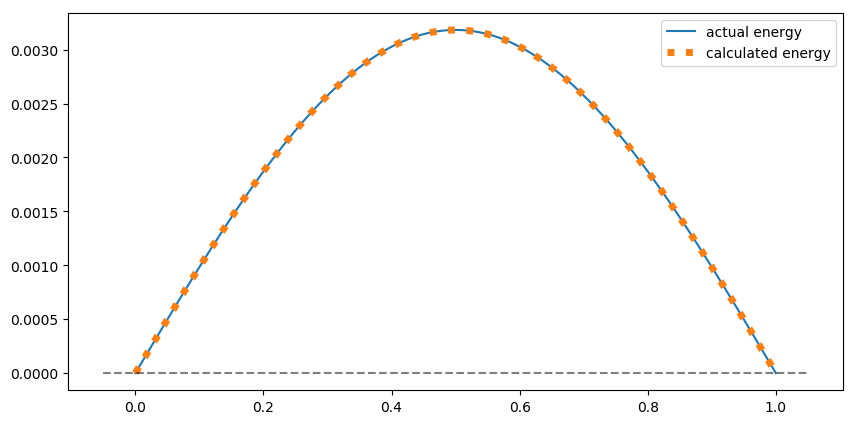

In [4]:
E_shoot = shoot(E-dE, E+dE, V, 0, L)
print(f"actual energy: {E:.8f}")
print(f"calculated energy: {E_shoot:.8f}")

res1 = solve_tise(E, V, 0, L, max_step=1e-3)
res2 = solve_tise(E_shoot, V, 0, L, max_step=1e-3)
fig, ax = plt.subplots(dpi=100, figsize=(10, 5))

ax.plot(res1.t, res1.y[0], label="actual energy")
ax.plot(res2.t, res2.y[0], label="calculated energy", ls=":", lw=5)
x_axis(ax)
ax.legend();

As we can see, the calculated energy is very close to the original energy, and there is almost no difference in the solutions when using either energy.

### Matching method

The shooting method, however, will not be sufficient for other potentials. Let's see why with the finite square well. We'll be using the potential 

$$V(x)=\begin{cases} -V_0 & -L \leq x \leq L \\ 0 & -L' \leq x < L \text{ or } L < x \leq L'\\ \infty & \text{otherwise}\end{cases}$$

for the finite square well (only difference from class is the infinite height barrier at a distance $L'$ from the origin, keeping the particle in a finite domain). Let's set $V_0=1$, $L=1$, $L'=5$, and then see what a solution looks like with $E=-0.5$.

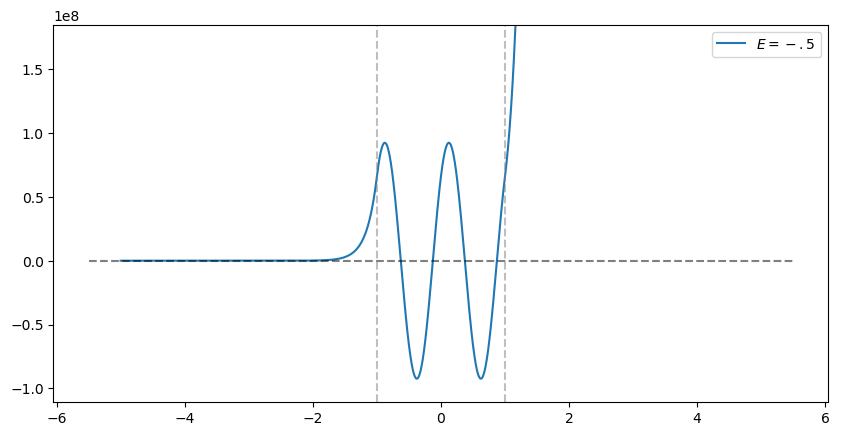

In [5]:
L, Lp, V0 = 1, 5, 1
V = lambda x: -V0 if abs(x) < L else 0
res = solve_tise(-.5, V, -Lp, Lp, max_step=1e-3)

fig, ax = plt.subplots(dpi=100, figsize=(10, 5))
ax.plot(res.t, res.y[0], label="$E=-.5$")
i = np.where(res.t >= L)[0][0]
ymin, ymax = res.y[0,:i].min(), res.y[0,:i].max()
ymin, ymax = ymin-.1*(ymax-ymin), ymax+.5*(ymax-ymin)
ax.set_ylim(ymin, ymax)
x_axis(ax)
hline(ax, [-L, L])
ax.legend();

In the classically forbiden region (that is, where $V(x)>E$), the solution blows up due to numerical error. As the solutions in these regions are exponetial functions, the "opposite" exponential takes over (that is, instead of the decaying solution $e^{-\alpha x}$, we get the increasing solution $e^{\alpha x}$). However, note that the solution is correct in the classically forbidden region on the left, which is where we start solving from. What does the solution look like if we start solving from the right?

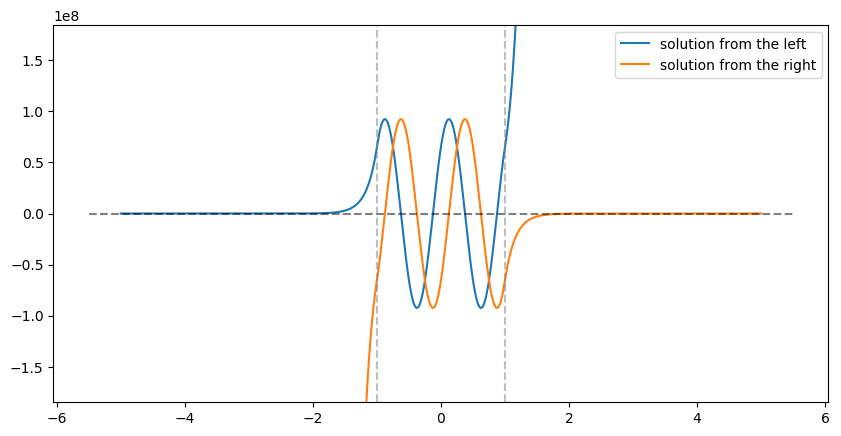

In [6]:
res1 = solve_tise(-.5, V, -Lp, Lp, max_step=1e-3)
res2 = solve_tise(-.5, V, Lp, -Lp, max_step=1e-3)

fig, ax = plt.subplots(dpi=100, figsize=(10, 5))
ax.plot(res1.t, res1.y[0], label="solution from the left")
ax.plot(res2.t, res2.y[0], label="solution from the right")
i = np.where(res1.t >= L)[0][0]
ymin, ymax = res1.y[0,:i].min(), res1.y[0,:i].max()
ymin, ymax = ymin-.5*(ymax-ymin), ymax+.5*(ymax-ymin)
ax.set_ylim(ymin, ymax)
x_axis(ax)
hline(ax, [-L, L])
ax.legend();

The solution from the right has the correct functional form, so we could "splice" the two solutions together to make a new solution. If we do this for this particular energy by taking the solution from the left all the way up to the classically beginning of the forbidden region on the right, and then taking the solution from the right, we get a discontinous solution, which does not satisfy the Schrodinger equations. However, if we change the energy to be close to an allowed energy...

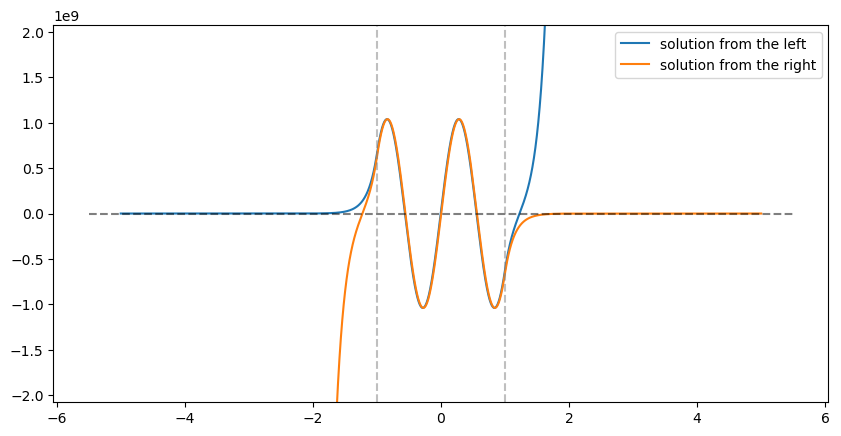

In [7]:
E = -.6
res1 = solve_tise(E, V, -Lp, Lp, max_step=1e-3)
res2 = solve_tise(E, V, Lp, -Lp, max_step=1e-3)

fig, ax = plt.subplots(dpi=100, figsize=(10, 5))
ax.plot(res1.t, res1.y[0], label="solution from the left")
ax.plot(res2.t, res2.y[0], label="solution from the right")
i = np.where(res1.t >= L)[0][0]
ymin, ymax = res1.y[0,:i].min(), res1.y[0,:i].max()
ymin, ymax = ymin-.5*(ymax-ymin), ymax+.5*(ymax-ymin)
ax.set_ylim(ymin, ymax)
x_axis(ax)
hline(ax, [-L, L])
ax.legend();

the solutions "match", and so the spliced solution is continous. This is the essence of the matching method. We shoot from the left and right up to some matching point, which should happen before any divergent behavior for both solutions, and then aim to match the function and the derivative at that point. As a root finding problem, if $\overrightarrow{\psi^{(E)}}$ is a solution from the left and $\overleftarrow{\psi^{(E)}}$ is a solution from the right, both with energy $E$, and $x_m$ is the match point, then we want to find the root of  

$$g(E) = \overrightarrow{\psi^{(E)}}\,'(x_m)-\frac{\overrightarrow{\psi^{(E)}}(x_m)}{\overleftarrow{\psi^{(E)}}(x_m)} \overleftarrow{\psi^{(E)}}\,'(x_m)\quad,$$

which will find the energy when the slope difference between the matched solutions is 0. For the matching method, we'll use the secant method, which is similar to Newton's root finding method, but we don't need to supply the derivative of $g$ (and is instead approximated). Below is a solution that we've matched.

converged: True
energy: -0.391453695424628


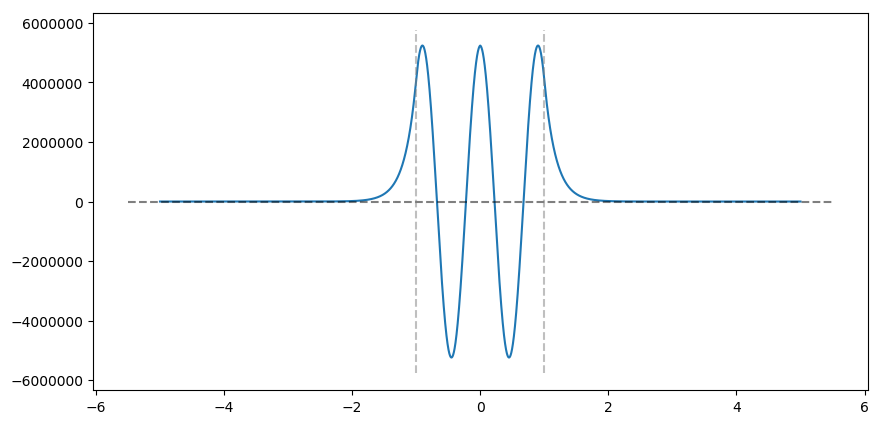

In [8]:
E = match(-.5, -.51, V, -Lp, Lp, 0)
print(f"energy: {E}")

x, psi = splice(E, V, -Lp, Lp, 0)

fig, ax = plt.subplots(dpi=100, figsize=(10, 5))
ax.plot(x, psi)
x_axis(ax)
hline(ax, [-L, L])

### Direct matrix method

The matching works well for general potentials, but we still need to search for the energy values. However, there is a method that can solve for the approximate energies directly, called the direct matrix method. Recall that we can write the TISE as 

$$\hat{H}\psi(x) = E \psi(x)$$

where $\hat{H} = -\frac{\hbar}{2m}\frac{d^2}{dx^2} + V(x)$. So finding the energies reduces to finding the eigenvalues of $\hat{H}$. However, we'll need to discretize $\hat{H}$ in order to use numerical methods for solving eigenvalues. By discretizing our domain into $N$ points as $x_j$ where $j ={0, 1, \dots, N-1}$, we can use the central difference formula to approxmiate the TISE as

$$-\frac{\hbar^2}{2m}\frac{\psi_{j+1} - 2\psi_{j} + \psi_{j-1}}{\Delta x^2} + V_j\psi_j = E\psi_j + O(\Delta x^2) \quad \text{for $j=1, 2, \dots, N-2$} $$

where $x_{j+1}-x_{j} = \Delta x$, $\psi_j = \psi(x_j)$, and $V_j = V(x_j)$. Rearranging with $k = \frac{\hbar^2}{2m\Delta x^2}$, $\psi_0=0$, we have the following system of equations:

\begin{align}
-k\psi_2 + (2k+V_1)\psi_1 &= E\psi_1 \\
-k\psi_3 + (2k+V_2)\psi_2  -k\psi_1 &= E\psi_2\\
-k\psi_4 + (2k+V_3)\psi_3  -k\psi_2 &= E\psi_3\\
\vdots\\
(2k+V_{N-2})\psi_{N-2}-k\psi_{N-3} &= E\psi_{N-2}
\end{align}

We can write this in matrix form,  

\begin{align}
\begin{bmatrix}
2k+V_1 & -k & 0 & \dots & 0 \\
-k & 2k+V_2 & -k & \ddots & \vdots \\
0 & -k & 2k+V_3 & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & -k \\
0 & \dots & 0 & -k & 2k+V_{N-2} 
\end{bmatrix}
\begin{bmatrix}\psi_1 \\ \psi_2 \\ \psi_3 \\ \vdots \\ \psi_{N-2} \end{bmatrix} = E 
\begin{bmatrix}\psi_1 \\ \psi_2 \\ \psi_3 \\ \vdots \\ \psi_{N-2} \end{bmatrix}
\end{align}

or more compactly, $H\psi = E\psi + O(\Delta x^2)$. Hence, we can approximate the eigenvalues of $\hat{H}$ by finding the eigenvalues of the discretized Hamiltonian $H$. In practice, the eigenvalues accumlate error for the higher energy states, but for small enough energy states and the matching method, we can now solve for the $n$th exited state of arbitrary potentials.

One system we can use to check our calculations is the quantum harmonic oscillator, whose analytic solutions are well known. Its potential is given by $V(x) = \frac{1}{2}m\omega^2x^2$, and its energy levels are $E_n = \hbar\omega (n+\frac{1}{2})$. Using the direct matrix method and letting $\omega=1$, $m=1$ and $h=1$, the plot below shows the difference between the analytic and diect matrix method. We can see that increasing the subdivision (and thus decreasing $\Delta x$) increases the accuracy of the estimate.

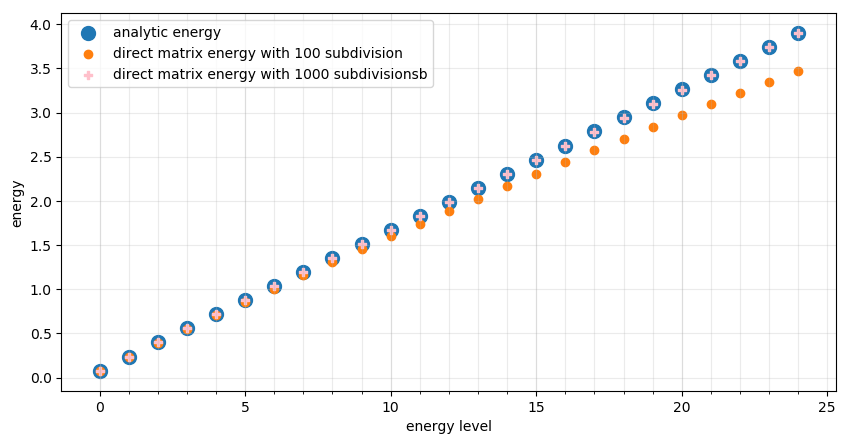

In [9]:
V = lambda x: 1/2*x**2
Es100 = solve_energies(V, -Lp, Lp, n=100)
Es1000 = solve_energies(V, -Lp, Lp, n=1000)
ns = np.arange(0, 25)

fig, ax = plt.subplots(dpi=100, figsize=(10, 5))
ax.scatter(ns, hbar*(ns+1/2), label="analytic energy", s=100)
ax.scatter(ns, Es100[ns], label="direct matrix energy with 100 subdivision")
ax.scatter(ns, Es1000[ns], label="direct matrix energy with 1000 subdivisionsb", marker="P", color="pink")
ax.set_xlabel("energy level")
ax.set_ylabel("energy")
ax.set_xticks(ns, minor=True)
ax.grid(alpha=.25)
ax.grid(alpha=.25, which="minor")
ax.legend();

Using the energies from the direct matrix method, below are some of the excited states for the quantum harmonic oscillator.

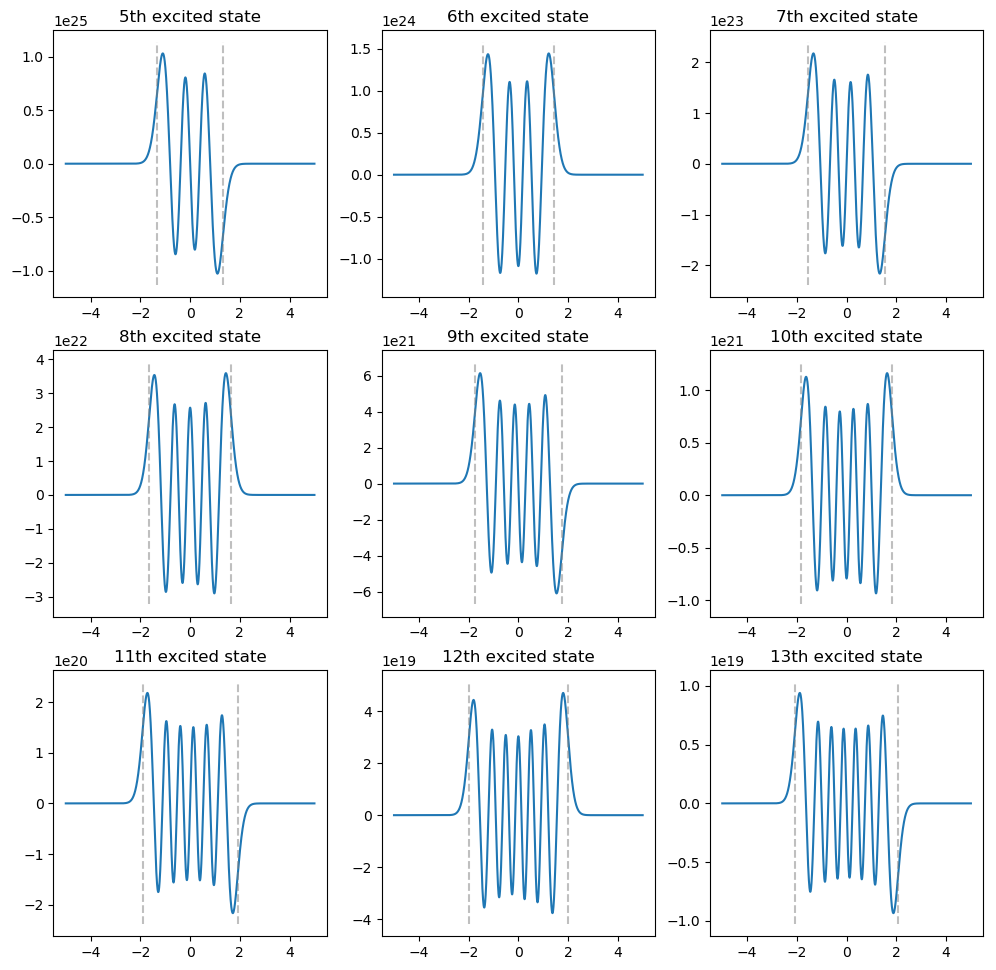

In [10]:
fig, axs = plt.subplots(3, 3, dpi=100, figsize=(12,12))
for i in range(9):
    E = Es1000[i+5]
    x, psi = splice(E, V, -Lp, Lp, .1)
    axs[i//3][i%3].plot(x, psi)
    axs[i//3][i%3].set_title(f"{i+5}th excited state")
    tp = np.sqrt(2*E)
    hline(axs[i//3][i%3], [-tp, tp])

Returning to the finite square well (with the same parameters from above), below are some of the wave functions for the higher excited states. Notice that after the 6th excited state, there is enough energy for the solution the classically forbidden region to be oscillatory.

energy of the final bound state: -0.1422
energy of the first unbound bound state: 0.0071


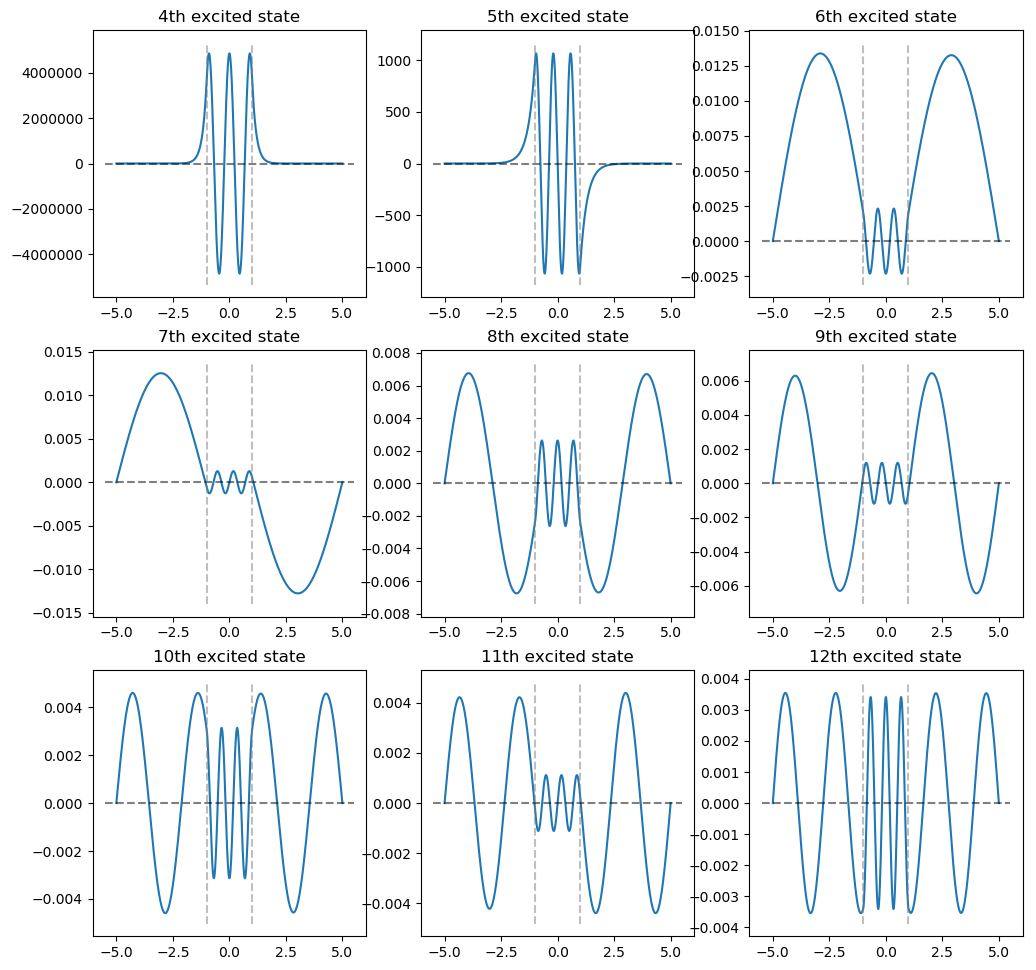

In [11]:
V = lambda x: -V0 if abs(x) < L else 0
Es = solve_energies(V, -Lp, Lp, n=1000)
fig, axs = plt.subplots(3, 3, dpi=100, figsize=(12,12))
for i in range(9):
    x, psi = splice(Es[i+4], V, -Lp, Lp, L)
    axs[i//3][i%3].plot(x, psi)
    axs[i//3][i%3].set_title(f"{i+4}th excited state")
    x_axis(axs[i//3][i%3])
    hline(axs[i//3][i%3], [-L, L])
    
print(f"energy of the final bound state: {Es[5]:.4f}")
print(f"energy of the first unbound bound state: {Es[6]:.4f}")

## Solving the time-dependent Schrodinger equation
Recall that the time-dependent Schrodinger equation (TDSE) is.
\begin{align}
i h \frac{\partial}{\partial x} \psi (x,t) = \hat{H} \psi\\
\end{align}

where $\hat{H}=-\frac{\hbar^2}{2m}\nabla^2 + V$ is the Hamiltonian operator, representing the total energy of the system.

This PDE is quite daunting until one applies seperation of variables to discover that the time evolution of the Schrodinger equation is just the product of the TISE and a phase term $e^{-i\hat{H}t/\hbar}$, giving you a solution to the TDSE.

However, this isn't always that useful in practice, as evolving forward the eigenstates of the time-independent solution is useful in the context of certain contexts and potentials, such as solving the TISE in an infinite square well. But for arbitrary initial conditions, while the particle will eventually settle into the time independent steady state solution, we can say very little about the transient solution (going from initial conditions to the steady state), particularly if the potential is non-linear. 
Further, our entire assumption of seperability goes out the window if the potential is time varying.

This clearly poses a problem, as there are certainly intresting problems we might want to model, such as how a electron settles into a bond orbital, as this could effect the initial stability of a chemical compound during bonding, or the dynamic interaction of multiple particles in a system. However, our current tools provide little to nothing of use to these problems.

### Numerical methods
This is where the numerical solutions of the TDSE become quite useful. The construction of the Schrodinger equation easily emits a formula for the time derivitive of $\psi$ at any given point. Thus, given a initial condition of the system, we should be able to solve this as a simple discretized finite differences (computing derivitives locally from a discretized domain) problem. However, we run into some complications. For one, we know that the actual function of the time evolution we are approximating is a complex exponential ($e^{-iH\Delta t/\hbar}$) for every time step, which is inherently unstable because any small purterbation to the real part will cause an exponenital difference in the output. This is a problem because second order finite differences methods (such as Runge-Kutta) is generally our go to tool for time evolution of states. However, the idea is still attractive because over very small time horizons, we can treat our potential as constant in time and also treat the current state of $\psi$ as the solution to some TISE which is being time evolved with our simple phase term. Because we are multiplying by each exponential at each timestep, and products of exponentials are a exponential of the sum of the exponential terms, this should still work out to being the correct time evolution.

In numerical analysis, when a system is particularly siff, such as some propogations of the Schrodinger equation, we often try and solve this with a implicit method, where we solve a optimization problem to find the most likely next state by estimating what the derivitive will be at the next state, and then steping backwards in time from there to try and find our current state. Instability is only in one direction of time, thus, because this effectively solves backwards in time, it will be stable for any unstable problem. Indeed, a version of this is often used for time evolving the Schrodinger equation, in a approximation known as the Crank-Nicolson Approximation, which is always stable in both forward and backwards time. However, these optimization problems often emmit numerically unsuitable solutions which degrade the accuracy of the solution.

So far, the quest for TDSE evolution in arbitary potentials is grim, while our discretized exponential is theoretically sound, our forward propogation is either unstable in space or time. However, we do know some things about the actual quantum mechanics at the heart of all of this math. For one, momentum is quantized discretely for any true solution of the Schrodinger equation. And in our simulation, because space is quantized discretely, so is the potential. The crux of our problem is really the Laplacian term in the Hamiltonian, because our approximations of spacial derivitives are inaccurate, making all of our solutions unstable. If there was some way of relating functions in space to functions of momentum, and then a easy way to take a derivitive which would not rely on a finite differences approximation. 

### Split-step operator method
Fortunately for us, the Fourier transform does just this, and the fast Fourier transform (FFT) is a very efficient and accurate way of computing this on a computer. The Fourier transform allows us to transform into momentum (phase) space and operate on the function from there. In phase space, derivitives are taken by multiplying by the phase variable times $i$. This makes it extremely easy to find the Laplacian in phase space as one simply has the multiply by $-k$. Because the Fourier transform accounts for the function at all points at once going into phase space, this same operation with the fast Fourier transform can be thought of as a high order approximation of the Laplacian which global convergence as the the number of quantized momenta grows large. What is better, is that in quantum mechanics, we have one expected wavenumber along with some uncertainty surrounding it. Because this is proportional to momentum, we know that, in momentum space, the function we are operating on will be quite simple, and conserving the wave number through steps should be trivial for the Fourier transform. By taking the Laplacian with the Fourier transform and applying the locally time independent potential assumption, we have stumbled on a variation of the split-step operator method, a spectral method for integrating the TDSE in time. 

\begin{align}
\psi(x, t + \Delta t) = e^{-iV(x,t) \Delta t /2\hbar} \mathbb{F}^{-1} [ e^{-ik^2 \Delta t / 2m\hbar}\mathbb{F}[\psi(x,t)]] + O(\Delta t^2)
\end{align}

For certain solutions, Strang splitting can also be applied to further improve performance. 


In [12]:
class TDSE_sim:
    def __init__(self, initial_position=0.0, uncertainty=0.5, wavenumber=40.0, domain=10.0, wavepacket_scaling=0.5, spacial_resolution=2**10, dt=1e-4, sim_length=1.0):
        self.spatial_res = spacial_resolution
        self.dt = dt
        self.num_timesteps = int(sim_length/dt)
        self.domain = domain
        
        # allow for periodic boundary conditions
        self.x = np.linspace(-self.domain/2, self.domain/2, num=self.spatial_res+1)[0:-1]
        self.k = 2*np.pi/(2*self.domain) * np.arange(-self.spatial_res/2, self.spatial_res/2)
        self.dx = self.x[1] - self.x[0]
        
        self.psi = (np.exp(-(self.x - initial_position)**2 /(4 * uncertainty**2)) * np.exp(1.0j * wavenumber * self.x))/((2 * np.pi * uncertainty**2)**(1.0/4))
        self.V = np.zeros_like(self.x)
        
        self.total_energy = []
        self.total_energy_timesteps = []
    
    def stepn(self, n):
        for i in range(n):
            psi_phase = np.fft.fftshift(np.fft.fft(self.psi))
            if i == 0:
                self.total_energy.append( np.abs(np.sum( np.fft.ifft(np.fft.ifftshift(psi_phase* 2*self.k)) + self.V )))

            # Kinetic Term
            psi_phase = np.exp(self.dt * -1.0j * (self.k**2)/2) * psi_phase
            psi = np.fft.ifft(np.fft.ifftshift(psi_phase))
            # Potential Term
            self.psi = np.exp(-1.0j * self.dt * self.V) * psi
        if len(self.total_energy_timesteps):
            self.total_energy_timesteps.append(self.total_energy_timesteps[-1] + n * self.dt)
        else:
            self.total_energy_timesteps.append(0)
            

### Example 1: Infinite square well aproximation
For a first experiment, we revisit the infinite square well, where we approximate a infinite square well with a continuous, piecewise function which grows extremely large after a certain point. We use this continuous function to ensure that the laplacian will be well defined for every point on the domain which helps with stability of the simulation. This is why it will appear that the wave part of $\psi$ extends too far into the well wall.

We get our initial conditions from the wavepacket solution to the TISE with a given wave number. For the purposes of numerical stability, $\hbar =1$. 

The following sims are run with a wavenumber of 5 and 40 to compare the output. The top plot represents the wave function and the potential, with the blue line being the real part and the orange line being the imaginary part. The bottom plot represents the magnitude of the wave function squared (that is, the probability density).

In [13]:
sim = TDSE_sim(wavenumber=5, domain=20)
# infinite potential well
sim.V[sim.x < -8] = 1e3* (sim.x[sim.x < -8]+8)**2
sim.V[sim.x > 8] = 1e3*(sim.x[sim.x > 8]-8)**2

In [14]:
Video('infinite_square_well.mp4')

In [15]:
sim = TDSE_sim(wavenumber=40, domain=20)

# infinite potential well
sim.V[sim.x < -8] = 1e3* (sim.x[sim.x < -8]+8)**2
sim.V[sim.x > 8] = 1e3*(sim.x[sim.x > 8]-8)**2

In [16]:
Video('infinite_square_well2.mp4')

As we can see, near the end of the sim, the particle is settling into the expected phase shifted TISE solution where it has a collection of places where it is 0 probability dependent on the wave number. In addition, because the well is much wider then the initial width of the particle, its energy level drops dramatically, but due to conservation of energy, its momentum goes up proportionally to account for this, resulting in the much higher wave number of the steady state solution then what we set in the initial conditions.

We can talk all day about the second order accuracy of the split-step method, but a much more compelling argument for the accuracy of our sim is in the conservation of energy in the Hamiltonian. Below, we present a graph showing the ratio of the total energy at a given second to the initial total energy of the particle. We see through the whole simulation that the Hamiltonian remains constant.

(0.99, 1.01)

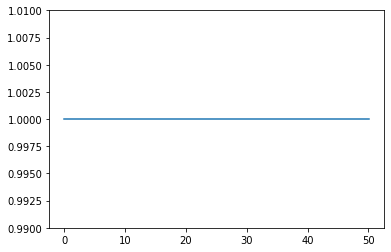

In [17]:
plt.plot(sim.total_energy_timesteps, np.array(sim.total_energy)/sim.total_energy[0])
ax = plt.gca()
ax.set_ylim(0.99, 1.01)

#### Example 2: Tunneling in a well

In [18]:
sim = TDSE_sim(initial_position=-5, wavenumber=5, domain=20)

# infinite potential well
sim.V[sim.x < -8] = 1e3* (sim.x[sim.x < -8]+8)**2
sim.V[sim.x > 1] = 16.625 + 5
sim.V[sim.x > 1.3] = 0
sim.V[sim.x > 8] = 1e3*(sim.x[sim.x > 8]-8)**2


In [19]:
Video('tunneling_in_well.mp4')

#### Example 3: Double Potential Well

In [20]:
sim = TDSE_sim(initial_position=-5, wavenumber=10, domain=20)

# infinite potential well
E_naut = 1.0
sim.V = 1.0*( 0.01* (1.3*sim.x)**4 - (1.3*sim.x)**2) +(16.625 + 8)

In [21]:
Video('double_potential_well.mp4')

## References

* Izaac, Joshua, and Jingbo Wang. Computational quantum mechanics. Springer International Publishing, 2018.

* Hermann, Mark R., and J. A. Fleck Jr. "Split-operator spectral method for solving the time-dependent Schrödinger equation in spherical coordinates." Physical Review A 38.12 (1988): 6000.

* Griffiths, David J., and Darrell F. Schroeter. Introduction to quantum mechanics. Cambridge University Press, 2018.

* https://math.mit.edu/~stevenj/fft-deriv.pdf

* http://cacs.usc.edu/education/cs653/03-1SpectralQD.pdf

* https://kitchingroup.cheme.cmu.edu/blog/2013/02/26/Derivatives-by-FFT/